<a href="https://colab.research.google.com/github/t-perniola/Denoising-Autoencoders-for-GRBs-detection/blob/main/Denoising_Autoencoder_for_GRBs_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving noise management in Autoencoders for Gamma Ray Burst (GRBs) detection

This project would focus on accounting for uncertainty and noise in autoencoders used for
Gamma Ray Burst (GRB) detection. The detection problem is framed as an anomaly
detection task over time series, which can be tackled by training an Autoencoder model on
background data (i.e. signals containing no GRB) and then using the reconstruction error as
a measure of the chance that a new sequence contains a notable event (such as a GRB).
Well performing models have already been trained, but they are suboptimal in how they
account for output noise, and they do not account explicitly for input noise. The goal is to
devise methods (e.g. neuro-probabilistic models) to account for uncertainty, so as to obtain
more reliable results.

## **Importing** useful libraries

In [40]:
import sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

sys.path.append('/content/drive/MyDrive/Colab Notebooks/AI4Ind')

Mounted at /content/drive


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import tensorflow as tf
from scipy.stats import skewnorm
from utils import *

## Let's **generate** our **syntethic** data

### Ensuring reproducibility
**Todo**: to also ensure robustness, we should iterate the process below over different seeds

In [5]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### **Training** data

We assume our data follows a **Skew-Normal** distribution, which is a simplification given that our data consists of multiple overlapping signals. Specifically, the original **background** signal is the sum of various components, including noise, external sources, etc. For now, we will use this as a **baseline**.

In [6]:
# Parameters that best describe the phenomenon
alpha_fit = 1.52731191e+00
mu_fit = 6.17068919e+01
sigma_fit = 1.70926014e+01

# Packing them
distribution_params = [alpha_fit, mu_fit, sigma_fit]

# Generating data according to the fitted distribution
def generate_skewnorm_data(alpha, mu, sigma, num_samples): # size: num of distribution to output
  data = skewnorm.rvs(alpha, loc=mu, scale=sigma, size=num_samples, random_state=42)
  return data

# How many training samples?
num_samples = 100000
training_data_original = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples)

### Skew-Normal Distribution

The **Skew-Normal distribution** is an extension of the normal distribution that includes a skewness parameter \\(\alpha\\), allowing it to model asymmetric data. It is defined as:

$$
\
f(x \mid \xi, \omega, \alpha) = \frac{2}{\omega} \phi\left( \frac{x - \xi}{\omega} \right) \Phi\left( \alpha \frac{x - \xi}{\omega} \right)
\
$$

where:

- \\(\xi\\) (*mu*): Location parameter.
- \\(\omega\\) (*sigma*): Scale parameter.
- \\(\alpha\\): Shape (skewness) parameter.
- \\(\phi(\cdot)\\): Standard normal probability density function (PDF).
- \\(\Phi(\cdot)\\): Cumulative distribution function (CDF) of the standard normal distribution.

When \\(\alpha = 0\\), the Skew-Normal distribution reduces to a standard normal distribution.


### **Reshaping** data

In [7]:
BIN_DURATION = 0.05 # 50ms

First, we need to **reshape** our data into smaller time-series, which will allow for a more structured analysis.
Specifically, we will create **lightcurves**, a common term for such time-series.

In this way our data will consist of $\textit{num_chunks}$ lightcurves (as rows), with each containing $\textit{chunks_size}$ bins (as columns). Each bin represents the count of gamma photons detected within a fixed time interval, which in our case is 50 ms.

*   If we have a 100-bins time-series, then it lasts 5 s!



In [8]:
# Reshaping data
def reshape_data(data, chunk_size):
  num_chunks = len(data) // chunk_size
  reshaped_data = data[:num_chunks * chunk_size].reshape((num_chunks, chunk_size))
  return reshaped_data, num_chunks

# Reshape training data
chunk_size = 100
training_data, num_chunks = reshape_data(training_data_original, chunk_size)
print(f"Shape of chunked data: {training_data.shape}")

Shape of chunked data: (1000, 100)


### **Validation** & **Dev-Test** set generation

We generate our validation and dev-test set by perturbing the background data: we will simply add to them some bursts that follow an **exponential decay** distribution.

We will add those bursts starting from *bin* *n.10* and they will last *20* *bins*.

*How many anomalies?*
* Respectively, the *8%* and the *5%* of our validation and dev-test
lightcurves will be anomalous.

In [9]:
## Select the percentage of anomalies
val_anomaly_perc = 0.08
dev_anomaly_perc = 0.05

#### Exponential Decay

> "A quantity is subject to exponential decay if it decreases at a rate proportional to its current value. Symbolically, this process can be expressed by the following differential equation, where $N$ is the quantity and $\lambda$ (lambda) is a positive rate called the exponential decay constant:  
>
> $$\frac{dN}{dt} = -\lambda N(t)$$
>
> The solution to this equation is:  
>
> $$N(t) = N_0 e^{-\lambda t}$$
>
> where $N(t)$ is the quantity at time $t$, $N_0 = N(0)$ is the initial quantity, that is, the quantity at time $t = 0$."
>
> — [Wikipedia](https://en.wikipedia.org/wiki/Exponential_decay)


#### **Perturbing** data
We follow the pipeline below:

1.   Generating validation and dev-test set, according to the Skew-Normal distribution
2.   Chunking data
3.   Perturbing them with exponential-decay bursts

In [10]:
# 1) Generate skew-normal datapoints
val_data = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples = num_samples // 3)
dev_data = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples = num_samples // 3)

# 2) Chunk data
val_data, _ = reshape_data(val_data, chunk_size)
dev_data, _ = reshape_data(dev_data, chunk_size)

# 3) Perturbate them with exp-decay bursts
peak_time = 10
burst_duration = 20

# Specify both even though they're currently equal
## we do that in case of eventual future adjustments
num_chunks_val = val_data.shape[0]
num_chunks_dev = dev_data.shape[0]
print(f"Shape of validation and dev-test data: {val_data.shape}")

Shape of validation and dev-test data: (333, 100)


**3.1)** For explanatory purposes, we firstly choose a single lightcurve and we plot both the signals

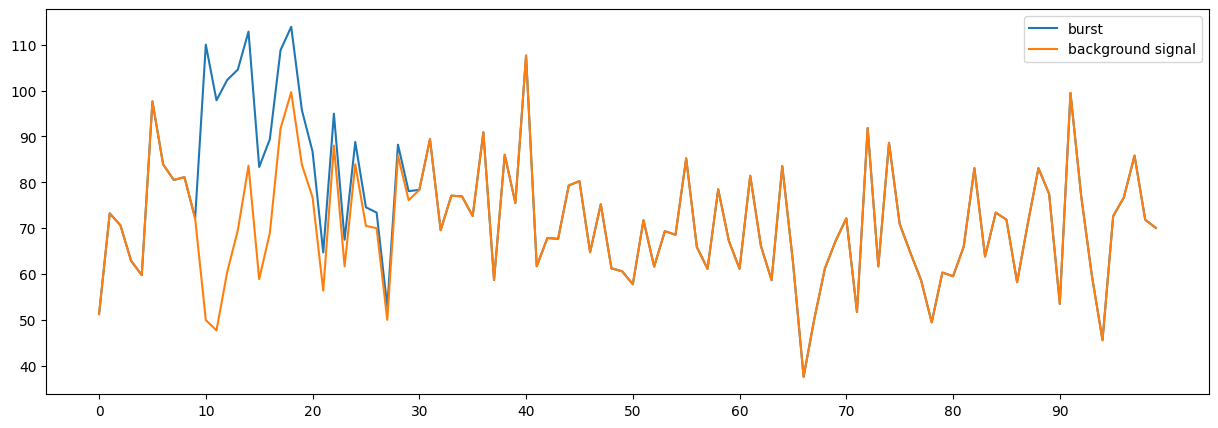

In [11]:
# 3.1) Plot both signals
i = np.random.randint(num_chunks_val)

## add burst to bg signal
perturbed_data = val_data.copy()
amplitude = 60
lambd = np.random.uniform(0.1, 0.2)
burst = amplitude * np.exp(-lambd * np.arange(burst_duration))
perturbed_data[i, peak_time:burst_duration + peak_time] += burst

## plot the original bg signal and the burst
plt.figure(figsize=(15, 5))
plt.plot(perturbed_data[i], label = "burst")
plt.plot(val_data[i], label = "background signal")
plt.xticks(np.arange(0, len(perturbed_data[i]), step=10))  # Ticks every 10 bins
plt.legend()
plt.show()

**3.2)** Now we apply the perturbation to all the selected validation and test light curves.

This function returns:
* a perturbed version of the given sets
* the indices of the time-series which contain the anomalies

In [12]:
# Apply bursts, generating indices within the function
def add_burst(data, anomaly_percentage, amplitudes, peak_time,
              burst_duration, num_chunks_eval):
  ## Parameters
  amplitude_lb = amplitudes["lb"]
  amplitude_ub = amplitudes["ub"]
  lambda_lb = 0.1
  lambda_ub = 0.2

  # Generate indices
  anomaly_indices = np.random.choice(
    num_chunks_eval, size=int(anomaly_percentage * num_chunks_eval),
    replace=False
    )

  ## Apply anomalies only to a selected percentage of light curves
  perturbed_data = data.copy()
  for i in anomaly_indices:
      amplitude = np.random.randint(amplitude_lb, amplitude_ub)
      lambd = np.random.uniform(lambda_lb, lambda_ub)
      burst = amplitude * np.exp(-lambd * np.arange(burst_duration))
      perturbed_data[i, peak_time:burst_duration + peak_time] += burst  # Add the anomaly

  return perturbed_data, anomaly_indices

# Apply bursts to val and test sets
amplitudes = {"lb": 40, "ub": 60} # Medium-level burst

val_data_perturbed, val_anomaly_indices = add_burst(
    val_data, val_anomaly_perc, amplitudes=amplitudes,
    peak_time=peak_time, burst_duration=burst_duration,
    num_chunks_eval=num_chunks_val
    )
dev_data_perturbed, dev_anomaly_indices = add_burst(
    dev_data, dev_anomaly_perc, amplitudes=amplitudes,
    peak_time=peak_time, burst_duration=burst_duration,
    num_chunks_eval=num_chunks_dev
    )

## **Data analysis**

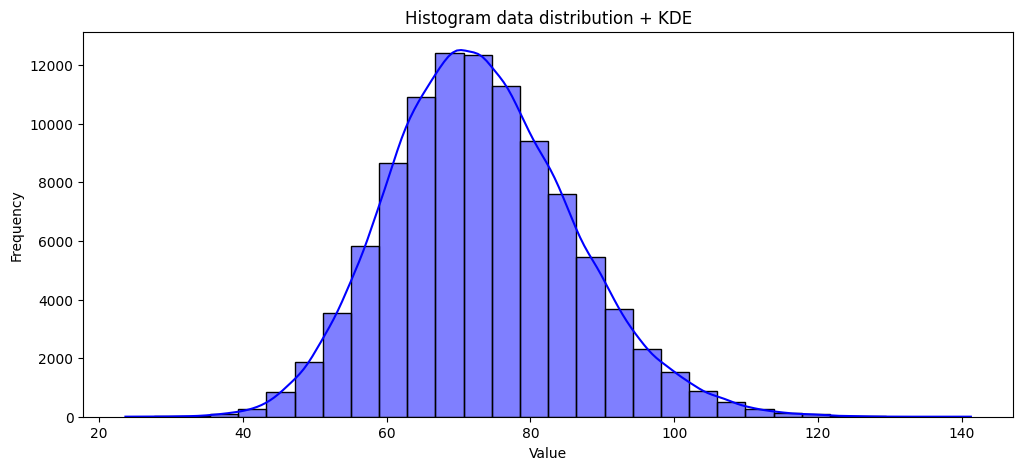

In [13]:
#@title Histogram plot to check the data distribution, that is a Skew-Normal
plt.figure(figsize=(12, 5))
sns.histplot(training_data_original, bins=30, kde=True, color="blue", alpha=0.5)
plt.title("Histogram data distribution + KDE")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

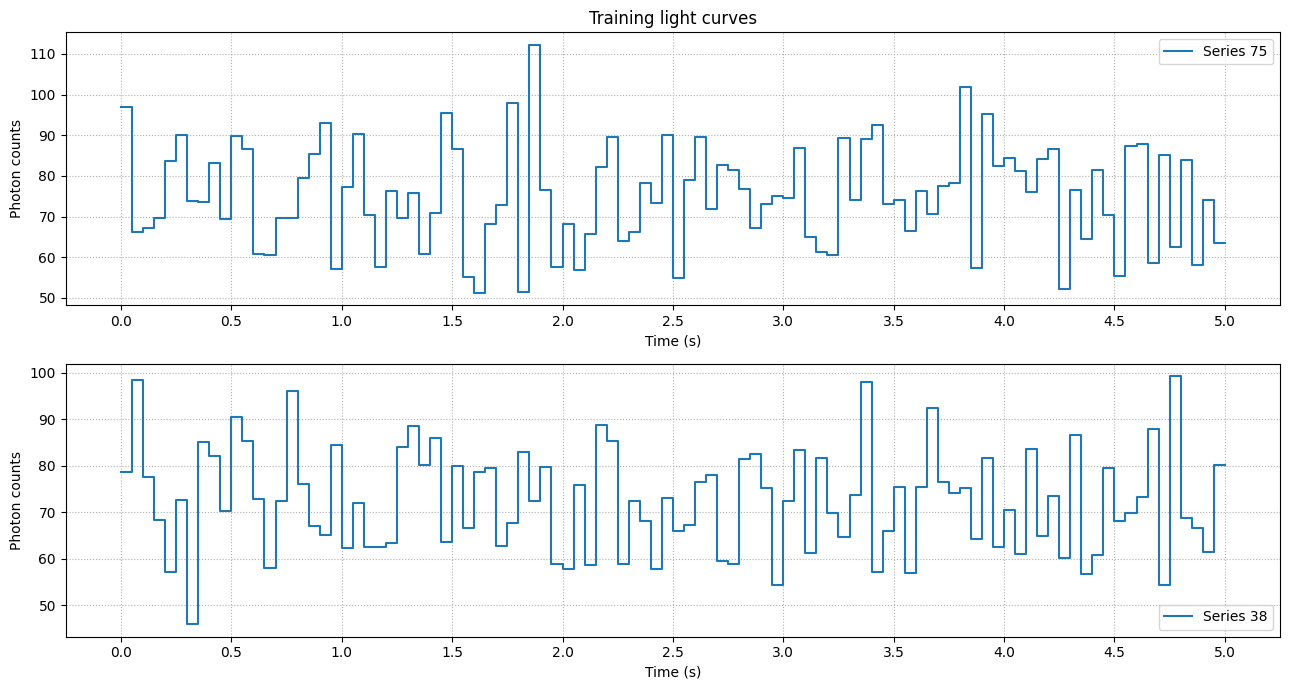

In [14]:
#@title Show training light curves, the background signals
show_box_lightcurves(training_data, chunk_size=chunk_size, size=2, label="Training", bin_duration = BIN_DURATION) # 50 ms

In the plot above, we show a training lightcurve where the x-axis accounts for the **bin duration**, that is of 50 milliseconds, as anticipated before. In this way, we are specifying the **width** of each time bin.
Moreover, as said before, each of these light curves represents a background signal, therefore we can expect a "regular" behavior.

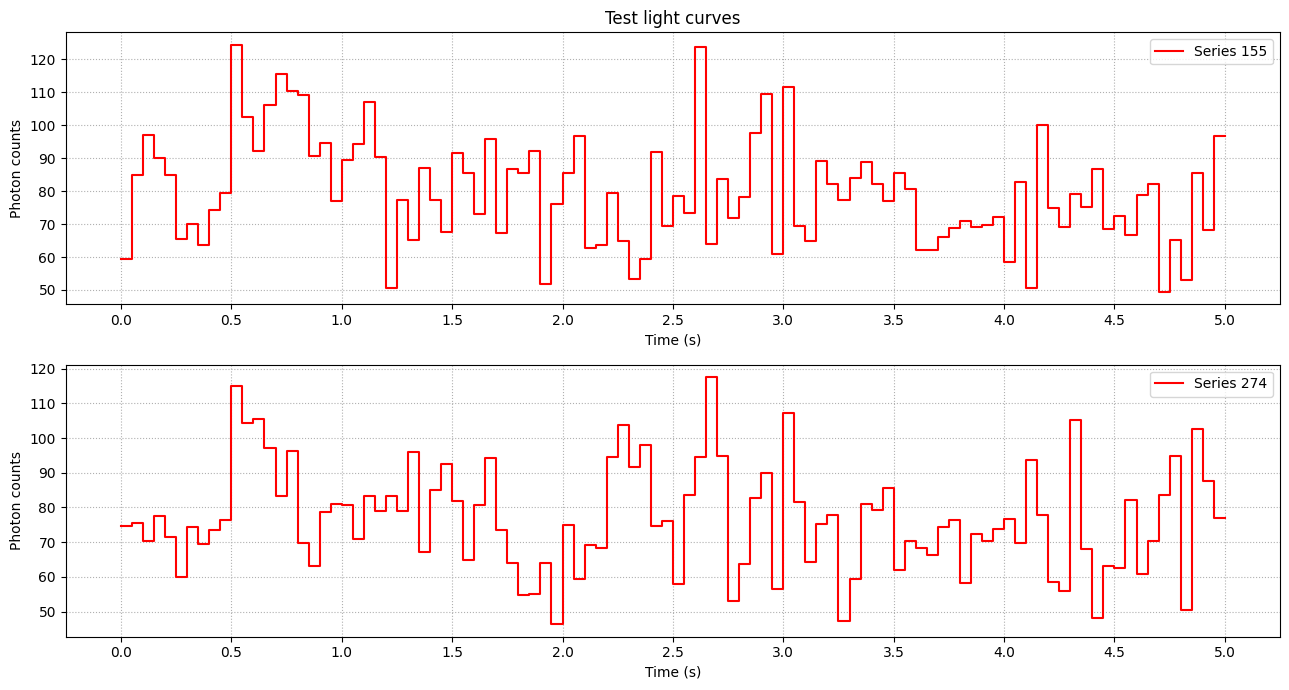

In [15]:
#@title Showing perturbed test lightcurves
show_box_lightcurves(dev_data_perturbed, chunk_size=dev_anomaly_indices, size=2,
                     label="Test", bin_duration = BIN_DURATION, color="red") # 50 ms

In [16]:
print(f"Real anomalies in dev-test light curves: {np.sort(dev_anomaly_indices).tolist()}")

Real anomalies in dev-test light curves: [1, 50, 87, 97, 106, 133, 155, 211, 250, 263, 266, 274, 280, 298, 305, 311]


As we can quite easily observe, both the validation and test light curves are slightly more pronounced around **bin n.10** (here the one starting at ***time(s)=0.5***, after the conversion) which presents a **peak** and a slight decay for a period of 20 bins.

## **Autoencoding**

We will train an autoencoder that will learn to reconstruct the original background signal. In this way, in the validation and test process, we will be able to detect potential anomalies if the reconstruction error is considerably higher than a certain threshold.

In particular, we will adopt a probabilistic approach instead: we will train for **MLE** for the current observations and we will learn the best parameters that maximize the likelihood of observing our input data. In particular, we will check if the predicted distribution, composed of mean, scale and skewness, aligns with the one of the test sample: the likelihood of observing the current sample given the predicted params and the learned distribution.

In [17]:
import keras
import tensorflow_probability as tfp
from scipy.optimize import root_scalar
from keras import layers, callbacks
from tensorflow.keras.utils import plot_model

In [18]:
#@title Normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_data = scaler.fit_transform(training_data)
val_data = scaler.transform(val_data)
val_data_perturbed = scaler.transform(val_data_perturbed)

### Custom Loss definition
We'll use a **Negative-Log-Likelihood** (NLL) for the Skew-Normal distribution. The model is learning to predict the best Skew-Normal distribution for each light curve. Namely, the AE learns to generate a probability distribution that represents the data, outputting its mean, variance and alpha value.

Basically, this loss function evaluates how likely each individual data point (from the input series) is under the predicted Skew-Normal distribution.

In [19]:
tfd = tfp.distributions

# Custom class definition
class SkewNormal(tfp.distributions.Distribution):
    def __init__(self, loc, scale, skewness, validate_args=False, allow_nan_stats=True, name="SkewNormal"):
        parameters = dict(locals())
        self.loc = tf.convert_to_tensor(loc, dtype=tf.float32)
        self.scale = tf.convert_to_tensor(scale, dtype=tf.float32)
        self.skewness = tf.convert_to_tensor(skewness, dtype=tf.float32)
        self.normal = tfd.Normal(loc=0.0, scale=1.0)  # Standard normal

        super(SkewNormal, self).__init__(
            dtype=tf.float32,
            reparameterization_type=tfd.NOT_REPARAMETERIZED,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            parameters=parameters,
            name=name.replace(" ", "_"),
        )

    # Log-probability density function (PDF) of the Skew-Normal distribution.
    def _log_prob(self, value):
        z = (value - self.loc) / self.scale
        normal_log_prob = self.normal.log_prob(z)
        skew_factor = 2 * self.normal.cdf(self.skewness * z)

        # Ensure numerical stability
        skew_factor = tf.clip_by_value(skew_factor, 1e-6, 1.0)  # Avoid log(0)
        return normal_log_prob + tf.math.log(skew_factor) - tf.math.log(self.scale)

In [20]:
# Negative Log-Likelihood for the Skew-Normal distribution.
def skew_normal_nll(y_true, params):
  mu, sigma, alpha = params[:, 0], params[:, 1], params[:, 2]

  # reshape to (batch_size, 1)
  mu = tf.expand_dims(mu, axis=-1)
  sigma = tf.expand_dims(sigma, axis=-1)
  alpha = tf.expand_dims(alpha, axis=-1)

  sn = SkewNormal(loc=mu, scale=sigma, skewness=alpha)
  return -tf.reduce_mean(sn.log_prob(y_true))

### The chosen architectures

We chose to implement both a Dense and a Conv1D autoencoder to compare different architectural biases:


*   **Dense autoencoder**: This model uses only fully connected layers. While it lacks any notion of temporal structure, it serves as a baseline model due to its simplicity and low inductive bias (it essenitally makes fewer assumptions about the structure of the input). It can be effective when anomalous patterns (e.g., bursts) are injected at fixed locations, as in our controlled perturbation setup. Its limited expressivity is also beneficial for anomaly detection, as overfitting to the training data can reduce sensitivity to novel patterns.

*   **Conv1D autoencoder**: This model introduces temporal awareness through convolutional filters applied across the time dimension. The encoder captures local temporal features and recurring patterns in the background signal, enabling better generalization to real-world variations. Even though the decoder does not attempt to reconstruct the time series point-by-point—since the output is a set of distribution parameters for the entire input chunk—the encoder still benefits from convolutional priors that make the model more responsive to time-localized anomalies. This architecture is better suited for detecting unexpected temporal variations, especially if bursts can vary in shape or position.



#### Dense autoencoder

In [21]:
def build_autoencoder(input_shape, units=64, num_layers=3):
  input_shape = (chunk_size, )
  input = keras.Input(shape = input_shape, dtype = "float32")
  x = input

  # Encoder
  for i in range(num_layers):
    x = layers.Dense(units // (2**i), activation = "relu")(x)

  # Decoder
  for i in reversed(range(num_layers-1)):
    x = layers.Dense(units // (2**i), activation = "relu")(x)
  decoder = layers.Dense(chunk_size, activation = "relu")(x)

  # Predict distribution parameters
  mu = layers.Dense(1, activation = "linear")(decoder)
  sigma = layers.Dense(1, activation = "softplus")(decoder)
  alpha = layers.Dense(1, activation = "linear")(decoder)

  output = layers.concatenate([mu, sigma, alpha], axis = 1)
  ae = keras.Model(input, output)
  ae.name = "ae_dense"

  return ae

#### Conv1D autoencoder

In [22]:
def build_conv1d_autoencoder(input_shape, filters=64, kernel_size=3, num_layers=2):
    input = keras.Input(shape=input_shape, dtype="float32")  # (chunk_size, 1)
    x = input

    # Encoder: stack num_layers of Conv1D + MaxPool
    for i in range(num_layers):
        x = layers.Conv1D(filters * (2**i), kernel_size, activation="relu", padding="same")(x)
        x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.GlobalAveragePooling1D()(x)  # (batch, latent_dim)

    # Decoder
    x = layers.Reshape((1, x.shape[-1]))(x)
    x = layers.UpSampling1D(size=1)(x)  # dummy step, keeps shape (1, latent_dim)

    # Predict distribution parameters
    mu = layers.Dense(1, activation="linear")(x)
    sigma = layers.Dense(1, activation="softplus")(x)
    alpha = layers.Dense(1, activation="linear")(x)

    output = layers.concatenate([mu, sigma, alpha], axis=-1) # (batch, 1, 3)
    output = layers.Flatten()(output) # (batch, 3)
    ae = keras.Model(input, output)
    ae.name = "ae_conv"

    return ae

### Training

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
]

#### Gridsearch

In [24]:
from itertools import product

# Hyperparams
params = {"units": [32, 64],
          "num_hidden": [1, 2, 3],
          "batch_size": [8, 16, 32],
          "filters": [16, 32, 64],
          "kernel_size": [3, 5]}

models = ["ae_conv"]

def gridsearch(models, params):
  results_search = []

  grid = list(product(*params.values()))
  params_names = list(params.keys())

  for model in models:
    for param_set in grid:
      param = {params_names[i]: param_set[i] for i in range(len(params_names))}
      print(f"Training model: {model}")
      print(f"Parameter config: {param}")
      if model == "ae_conv":
        ae = build_conv1d_autoencoder(input_shape = (chunk_size, 1),
                                      filters = param["filters"],
                                      kernel_size = param["kernel_size"],
                                      num_layers = param["num_hidden"])
      else:
        ae = build_autoencoder(input_shape = (chunk_size, ),
                              units = param["units"],
                              num_layers = param["num_hidden"])

      ae.compile(optimizer = "adam", loss = skew_normal_nll)
      history = ae.fit(x = training_data, y = training_data,
                      validation_data = (val_data_perturbed, val_data_perturbed),
                      epochs = 50, batch_size = param["batch_size"],
                      callbacks=callbacks, verbose=0)

      # Store results: we save the validation loss for later comparison
      val_loss = history.history['val_loss'][-1]
      result = {**param, 'model': model, 'val_loss': val_loss}
      results_search.append(result)

    return results_search

#results_search = gridsearch(models, params)

In [25]:
# Convert results to pandas DataFrame for easier analysis
#df_results_search = pd.DataFrame(results_search)

# Show the DataFrame with validation losses for all configurations
#print(df_results_search)

# Selecting the best configuration: you can choose the one with the minimum validation loss
#best_config_ae = df_results_search.loc[df_results_search["ae"]['val_loss'].idxmin()]
#best_config_ae_conv = df_results_search.loc[df_results_search["ae_conv"]['val_loss'].idxmin()]

#print(f"Best configuration for dense:\n {best_config_ae}")
#print(f"Best configuration for conv1D:\n {best_config_ae_conv}")

#### Select the best config for both models

In [26]:
best_config = {"ae": {"units": 64, "num_layers": 3, "batch_size": 8},
               "ae_conv": {"filters": 64, "units": 64, "kernel_size": 3,
                           "num_hidden": 2, "batch_size": 8}}

In [27]:
ae = build_autoencoder(input_shape = (chunk_size, ),
                       units = best_config["ae"]["units"],
                       num_layers = best_config["ae"]["num_layers"])
ae.summary()

Model: "ae_dense"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      6,464 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │        544 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      2,112 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 100)       │      6,500 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        101 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        101 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        101 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3)         │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0],    │
│                     │                   │            │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,531 (72.39 KB)

 Trainable params: 18,531 (72.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1.4503 - val_loss: 1.4454
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4180 - val_loss: 1.4423
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4153 - val_loss: 1.4411
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4130 - val_loss: 1.4394
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4110 - val_loss: 1.4384
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4102 - val_loss: 1.4370
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4092 - val_loss: 1.4370
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4084 - val_loss: 1.4361
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4075 - val_loss: 1.4360
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4073 - val_loss: 1.4373
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4069 - val_loss: 1.4386
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

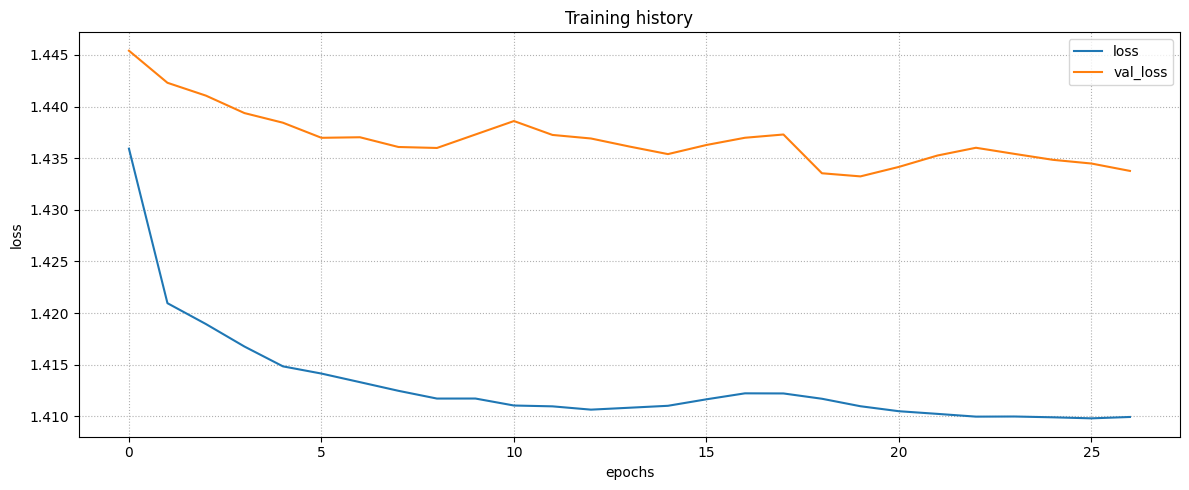

In [28]:
ae.compile(optimizer = "adam", loss = skew_normal_nll)
history = ae.fit(x = training_data, y = training_data,
                 validation_data = (val_data_perturbed, val_data_perturbed),
                 epochs = 50, batch_size = best_config["ae"]["batch_size"],
                 callbacks=callbacks)
show_history(history)

> As we can see, this type of model is more sensitive to noise or variance in the validation set, leading to noticeable fluctuations in the validation loss. The primary reasons for this behavior are that the model suffers from parameter inefficiency: with a higher capacity than a Conv1D model, it attempts to adjust numerous weights to fit subtle changes, which results in slower convergence.

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.4367 - val_loss: 1.4418
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.4105 - val_loss: 1.4298
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.4085 - val_loss: 1.4291
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.4095 - val_loss: 1.4290
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4075 - val_loss: 1.4284
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4089 - val_loss: 1.4283
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4071 - val_loss: 1.4282
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4069 - val_loss: 1.4289
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4069 - val_loss: 1.4273
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4063 - val_loss: 1.4280
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4062 - val_loss: 1.4267
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/s

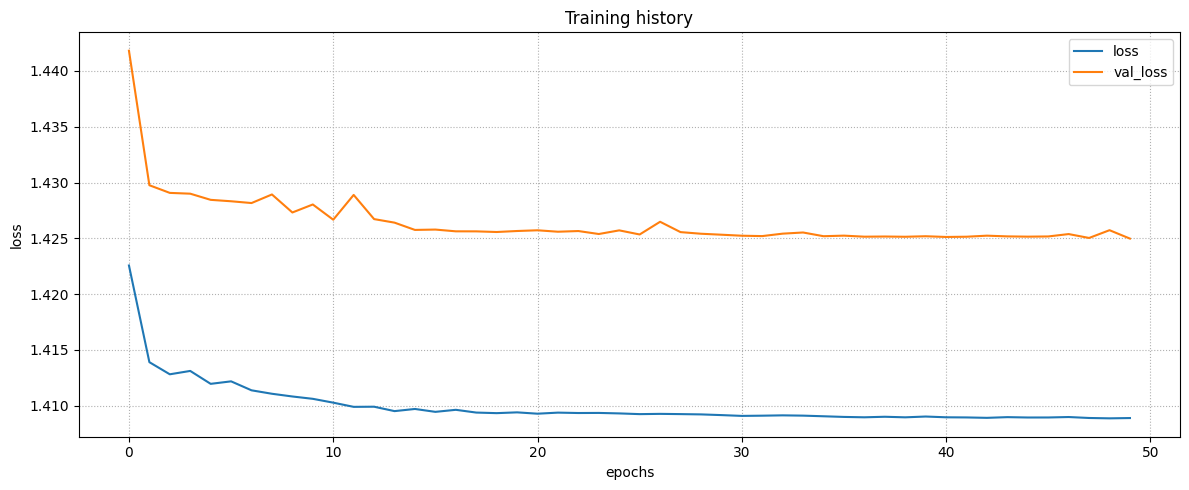

In [29]:
ae_conv = build_conv1d_autoencoder(input_shape = (chunk_size, 1),
                                   filters = best_config["ae_conv"]["filters"],
                                   kernel_size = int(best_config["ae_conv"]["kernel_size"]),
                                   num_layers = best_config["ae_conv"]["num_hidden"])
ae_conv.compile(optimizer = "adam", loss = skew_normal_nll)
history_conv = ae_conv.fit(x = training_data, y = training_data,
                           validation_data = (val_data_perturbed, val_data_perturbed),
                           epochs = 50, batch_size = best_config["ae_conv"]["batch_size"],
                           callbacks=callbacks)
show_history(history_conv)

> On the other hand, the Conv1D architecture shows a smoother loss because it basically generalizes better on structured data, while it has a built-in smoothing behavior through the convolutional operation.

#### Percentile-based **threshold** estimation
Let's choose the Conv1D model. First, we're gonna compute likelihoods for a *newly training set* (to avoid optimistic biases) and the standard deviation relative to the mean.

In [30]:
# Generate a fresh background signal
th_data = generate_skewnorm_data(alpha_fit, mu_fit, sigma_fit, num_samples)
th_data, _ = reshape_data(th_data, chunk_size)
th_data = scaler.transform(th_data)

# Choose the model
model = ae_conv

# Compute training likelihoods
train_likelihoods = compute_likelihoods(th_data, model, num_chunks,
                                        skew_normal_nll)

# Convert the list to a numpy array for easier computation
train_likelihoods = np.array(train_likelihoods)

# Compute the Standard Deviation of the training likelihoods
stdev_train_ll = np.std(train_likelihoods)

# Compute the mean likelihood
mean_train_ll_conv = np.mean(train_likelihoods)

# Print the standard deviation
print(f"Standard deviation of training likelihoods: {stdev_train_ll}")

Standard deviation of training likelihoods: 0.07315075397491455


##### Compute the fixed threshold, up to the **99.8th percentile**, to determine anomalies

In [31]:
threshold_perc = np.percentile(train_likelihoods, 99.8)
print(f"99.8th Threshold: {threshold_perc:.4f}")

99.8th Threshold: 1.6057


### **Burst strength evaluation**

In this section, we will evaluate our model using different versions of the same perturbed test set, each with varying burst strengths. The goal is to find the optimal balance between:

* The **distinctiveness** of the background signal and the anomalous signals, ensuring that the test likelihood is sufficiently higher than the baseline, clearly reflecting the distinction between normal and anomalous signals.

* The **burst strength**, generating anomalies that are detectable but not overly obvious, preventing the anomalies from standing out too clearly.

A secondary, yet technically important, goal behind this analysis—though it might seem *trivial* at first—is to assess the **robustness** of the model, given that we generally expect performance to improve as burst strength increases. Specifically, we aim to avoid situations where the model saturates too early, or fails to effectively capture the anomaly signal. In other words, we are verifying whether the model has extracted all the useful information from the data. This can be done by examining performance metrics: for example, if the *F1-score* does not improve as the burst strength increases, it suggests that the model is not adequately responding to the changing anomaly characteristics, signaling a potential limitation in its ability to generalize.


In [32]:
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, classification_report,
    confusion_matrix, precision_score, recall_score
)

# Setting perturbation levels
burst_strengths = {
    "Weak": {"lb": 25,  "ub": 40},
    "Medium": {"lb": 40, "ub": 60},
    "Strong": {"lb": 60, "ub": 80},
    "Very strong": {"lb": 80, "ub": 100}
}

# Models to iterate on
models = [ae, ae_conv]

# Defining the dict for storing the results of the evaluation
results = {model.name: {label: {
    "Avg ll": None, "Std dev": None, "AUC": None,
    "Precision": None, "Recall": None, "F1": None,
    "Best Threshold (F1)": None
} for label in burst_strengths.keys()}
           for model in models}

Let's evaluate and plot the performances of the model for each of the validation set version, for each of the chosen metrics:


*   ROC curve
*   AUC
*   Precision-Recall curve
*   F1-score



Evaluating model: ae_dense


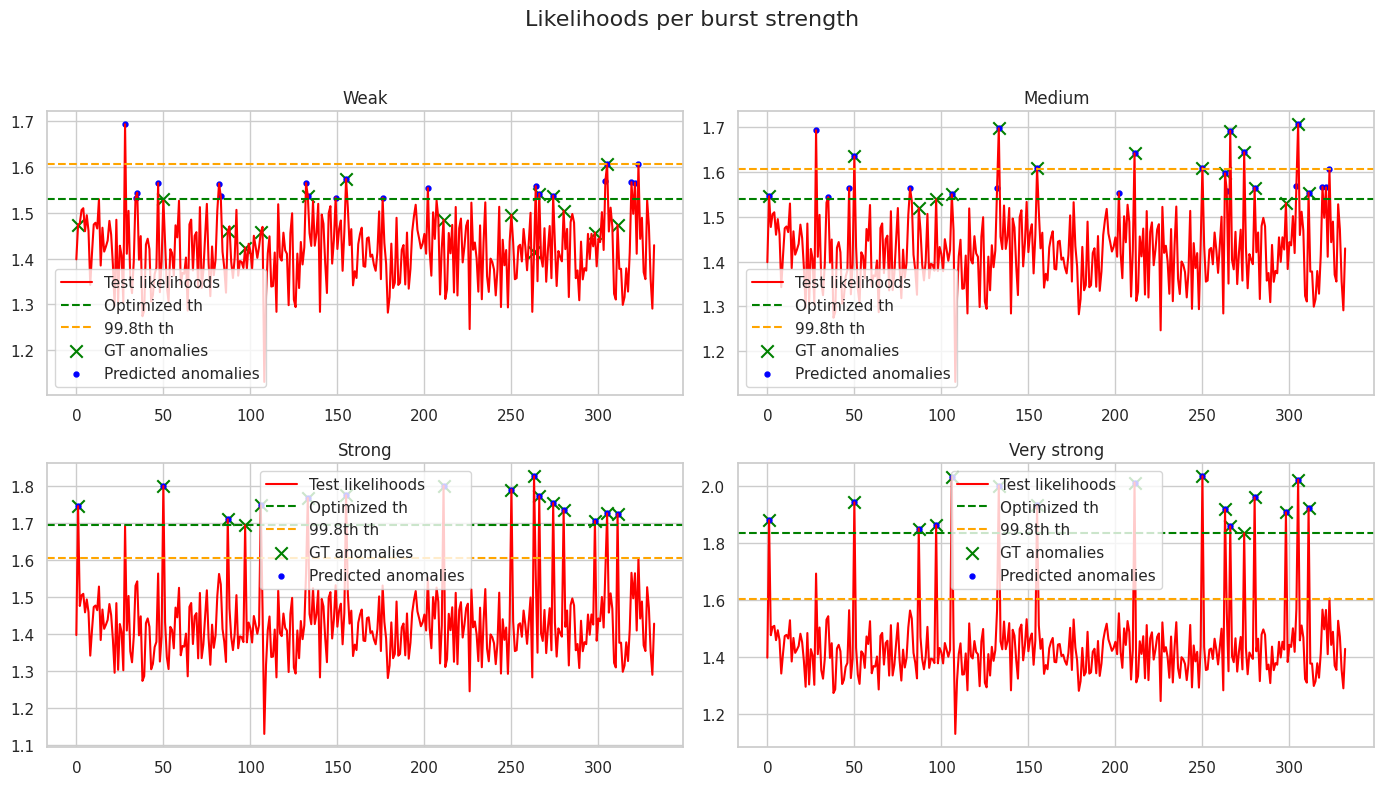

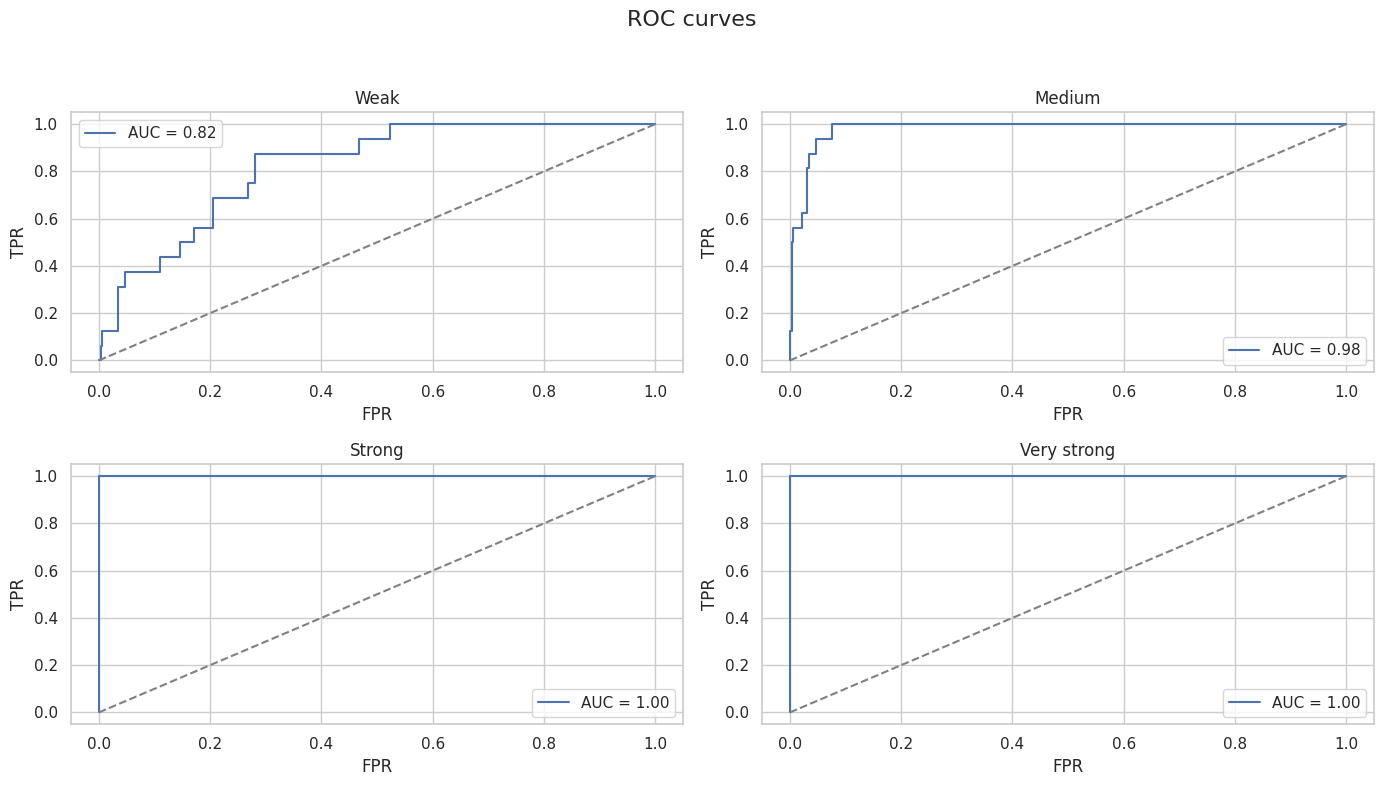

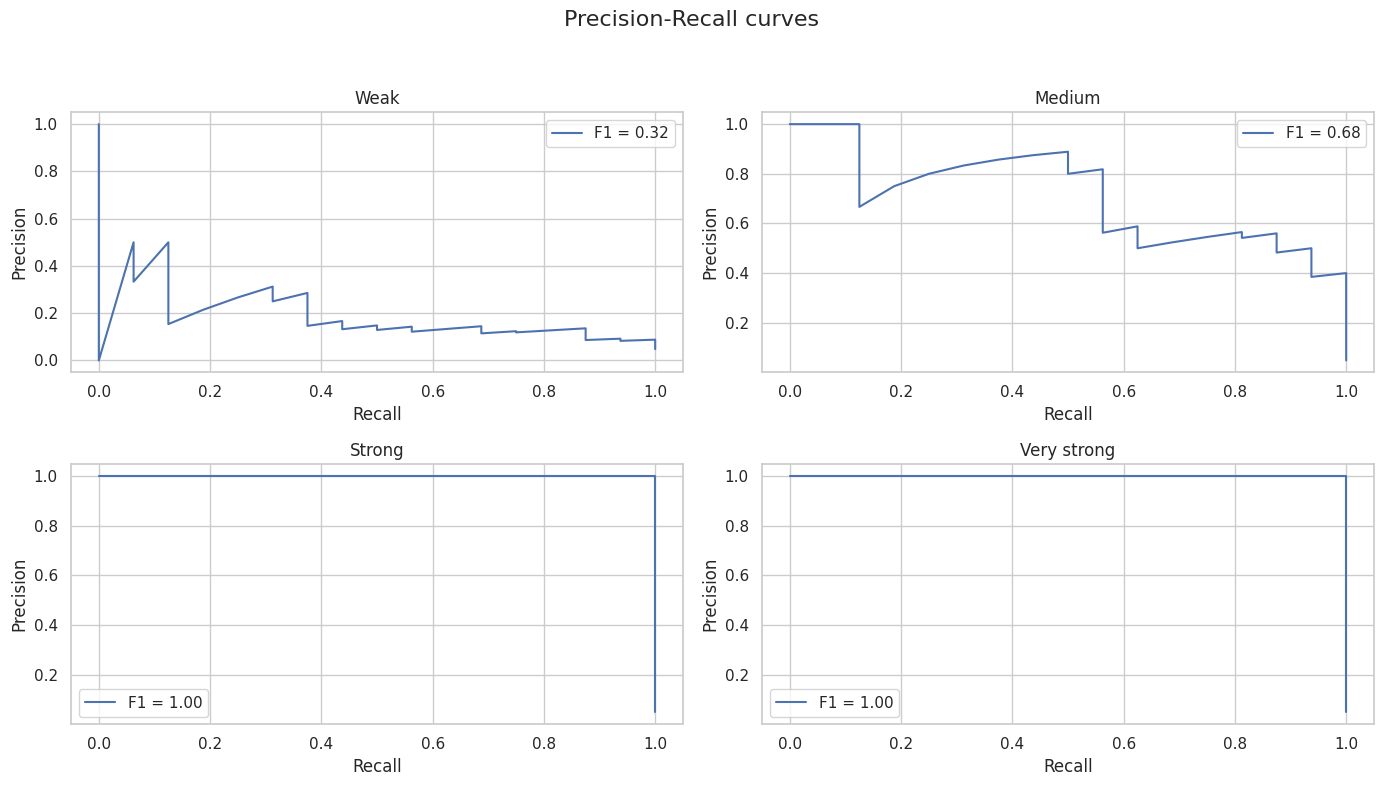

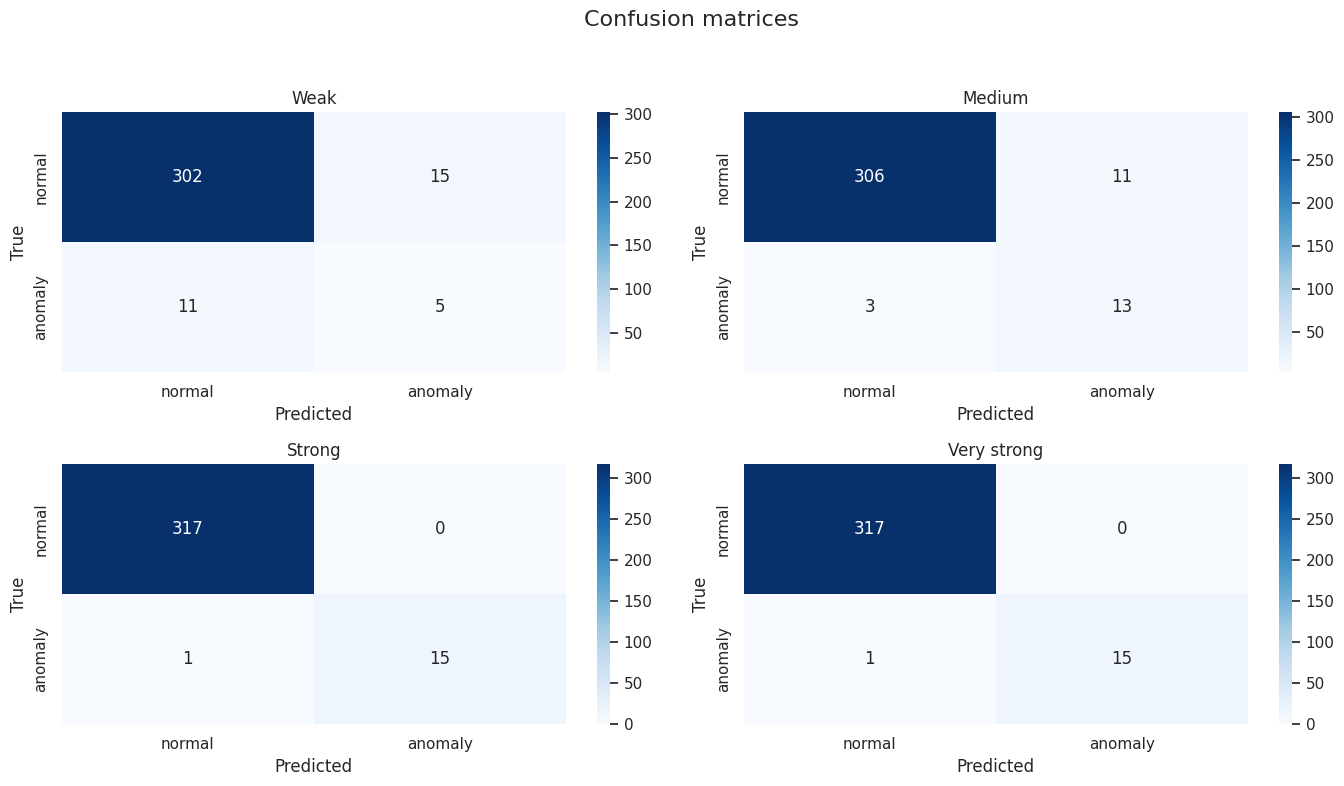

Evaluating model: ae_conv


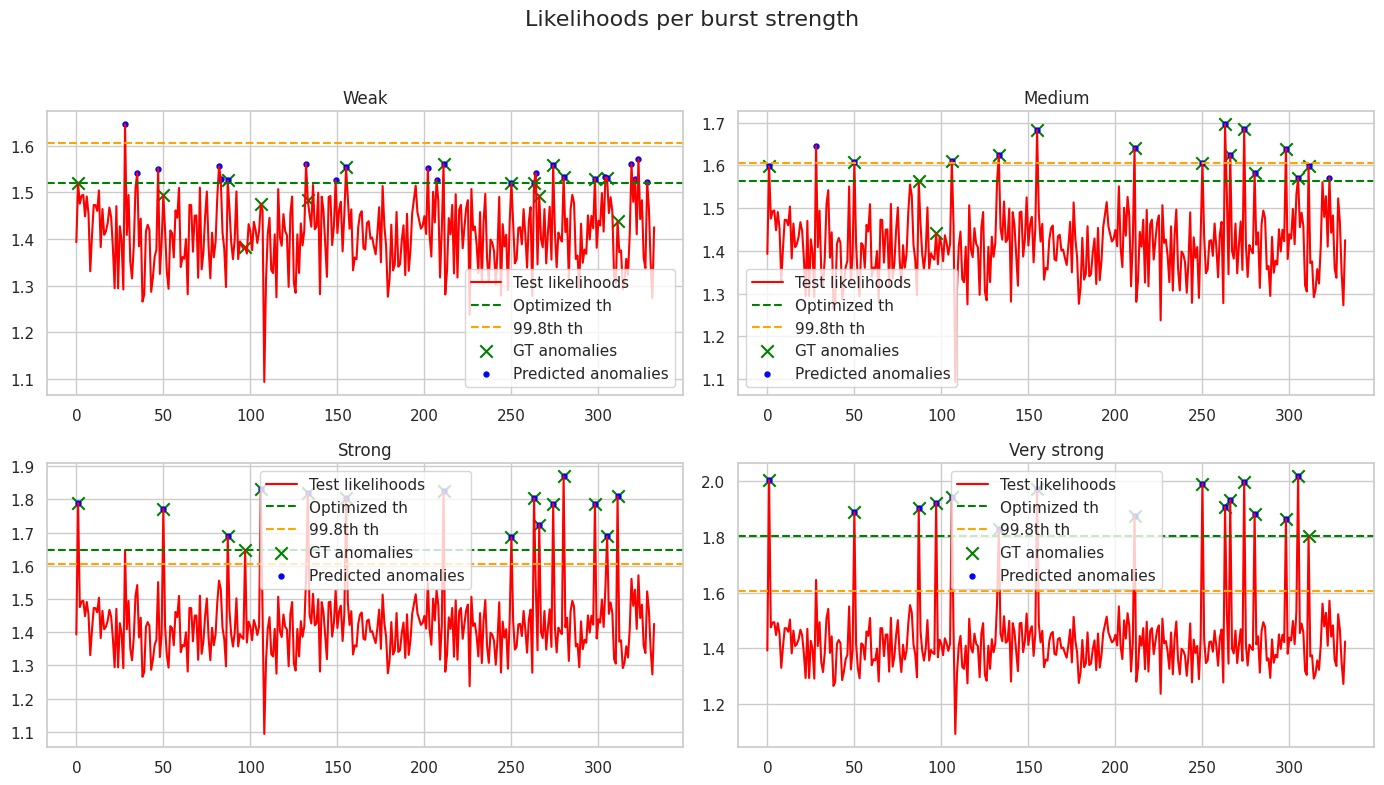

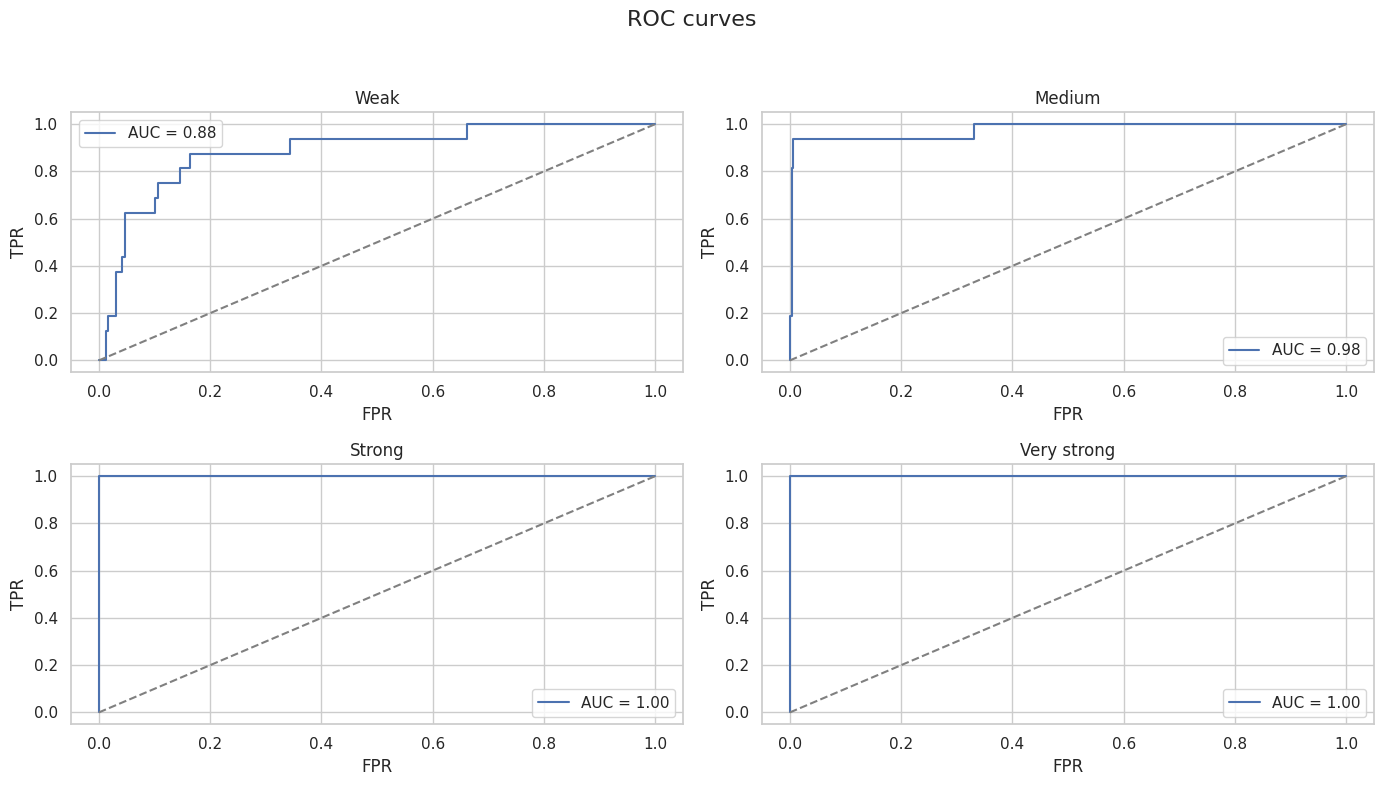

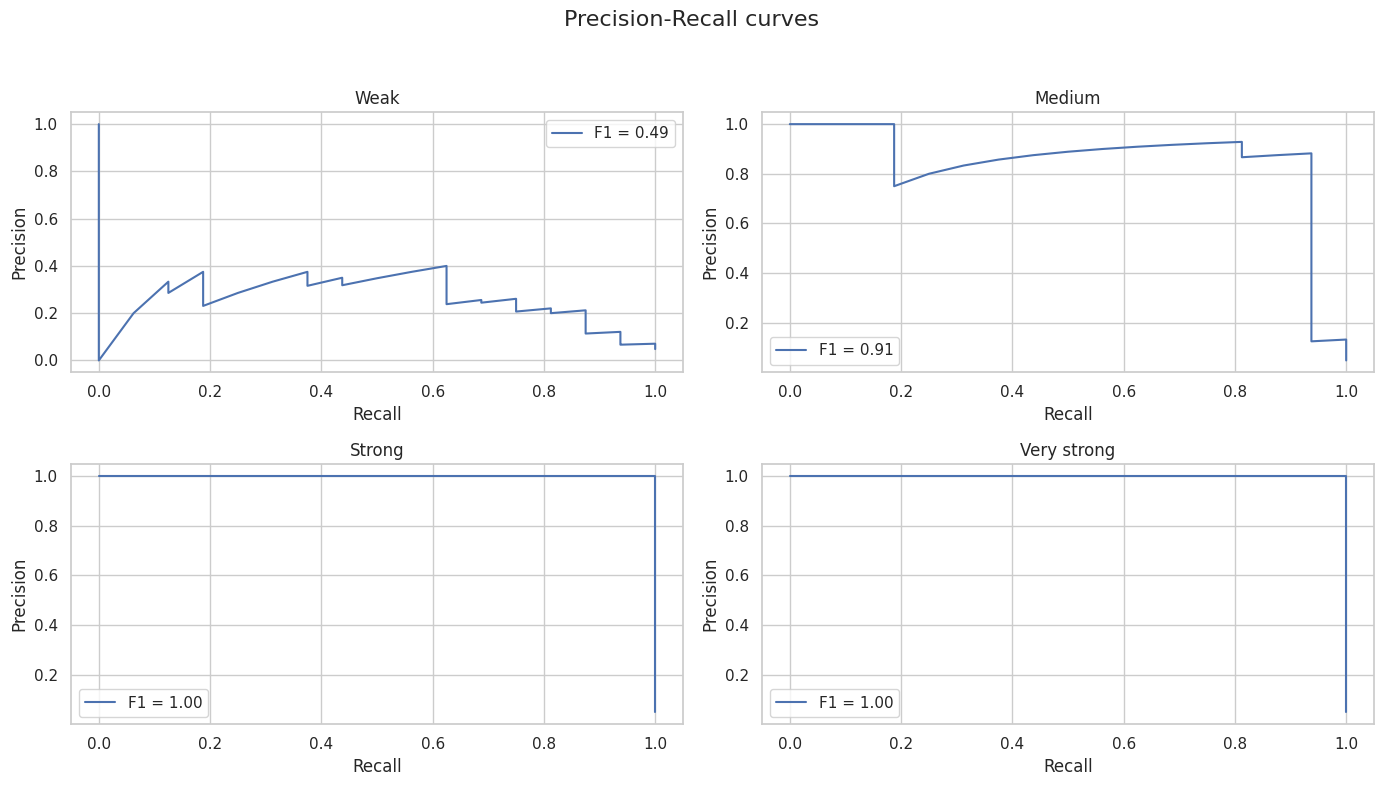

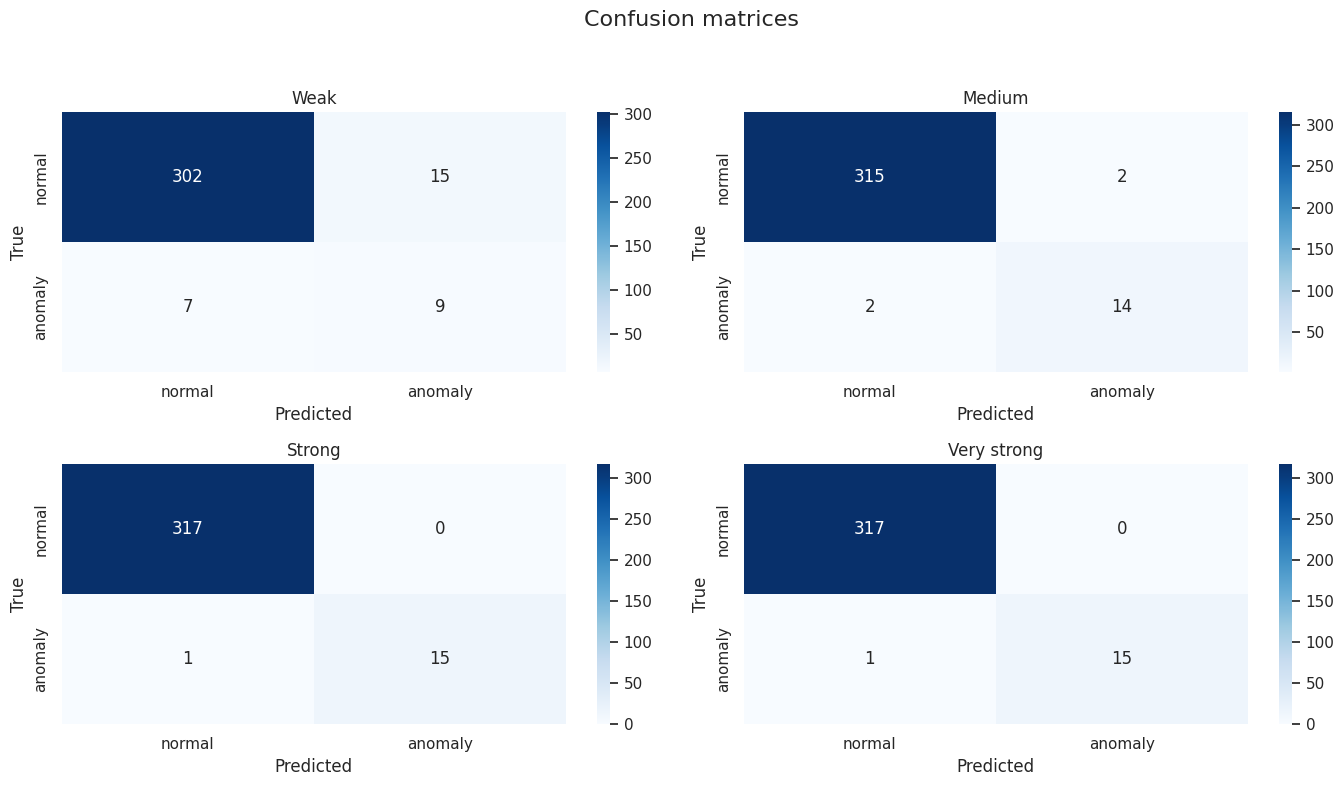

In [33]:
# Evaluating and plotting
for model in models:
  print(f"Evaluating model: {model.name}")
  evaluate_and_plot_per_strength(dev_data, results, model,
                                 dev_anomaly_indices, burst_strengths, scaler,
                                 train_likelihoods, num_chunks_dev,
                                 threshold_perc, peak_time, burst_duration
  )

(In some cases, using the 1D-convolutional architecture makes the difference between *strong* and *very strong* signals more apparent compared to the dense architecture.)

This is likely because the Conv1D model is better at leveraging the **temporal structure** of the bursts and capturing fine-grained differences in intensity, whereas the dense model may be more prone to overlooking these subtleties or averaging them out.

Moreover, we clearly observe that the model responds well to increasing burst strengths, confirming its robust generalization capability.

In [34]:
# Showing results
for model in models:
  print(f"Model: {model.name}")
  df_results = pd.DataFrame(results[model.name]).T
  print(df_results.round(4))
  print("------------------------------------------------------------------")

Model: ae_dense
             Avg ll  Std dev     AUC  Precision  Recall      F1  \
Weak         1.4199   0.0733  0.8239     0.2500  0.3125  0.3243   
Medium       1.4249   0.0819  0.9813     0.5417  0.8125  0.6829   
Strong       1.4323   0.1014  1.0000     1.0000  0.9375  1.0000   
Very strong  1.4410   0.1323  1.0000     1.0000  0.9375  1.0000   

             Best Threshold (F1)  
Weak                      1.5302  
Medium                    1.5391  
Strong                    1.6957  
Very strong               1.8344  
------------------------------------------------------------------
Model: ae_conv
             Avg ll  Std dev     AUC  Precision  Recall      F1  \
Weak         1.4133   0.0728  0.8849      0.375  0.5625  0.4878   
Medium       1.4182   0.0825  0.9765      0.875  0.8750  0.9091   
Strong       1.4259   0.1047  1.0000      1.000  0.9375  1.0000   
Very strong  1.4332   0.1303  1.0000      1.000  0.9375  1.0000   

             Best Threshold (F1)  
Weak                

**Which is the best model?**

We notice that the Conv1D may model the **distribution more precisely**, since it has a lower average likelihood, which is clearly a good sign. Moreover, it has also a lower standard deviation, which means that it is more certain in its estimate of the background signal distribution.

On the other hand, it **slightly** **underperforms** on classification metrics! This may suggest it underestimates subtle anomalies or fails to clearly separate borderline cases (especially for *weak* signals).


### **Final evaluation**: choose a burst strength level

For the final evaluation, we will evaluate both models and we will adopt a **medium**-strength perturbation level as our test condition. This level offers a **trade-off** between anomaly detectability and realism, allowing us to assess performance under the previous conditions.

This new test set will act as a *real test* set, an unseen one.

In [157]:
# Choose perturbation level
strength_lvl = "Medium"

# Choose the anomaly percentage
test_anomaly_perc = 0.03

# Retrieve the best threshold for the specified level of perturbation..
# ..for the Conv1D model
best_threshold_conv = results[ae_conv.name][strength_lvl]["Best Threshold (F1)"]
print(f"Best threshold (Conv1D) for {strength_lvl.lower()} strength level of perturbation: {best_threshold_conv:.2f}")

# ..for the Dense model
best_threshold_dense = results[ae.name][strength_lvl]["Best Threshold (F1)"]
print(f"Best threshold (dense model) for {strength_lvl.lower()} strength level of perturbation: {best_threshold_dense:.2f}")

Best threshold for medium strength level of perturbation: 1.56
Best threshold for medium strength level of perturbation: 1.54


##### Conv1D

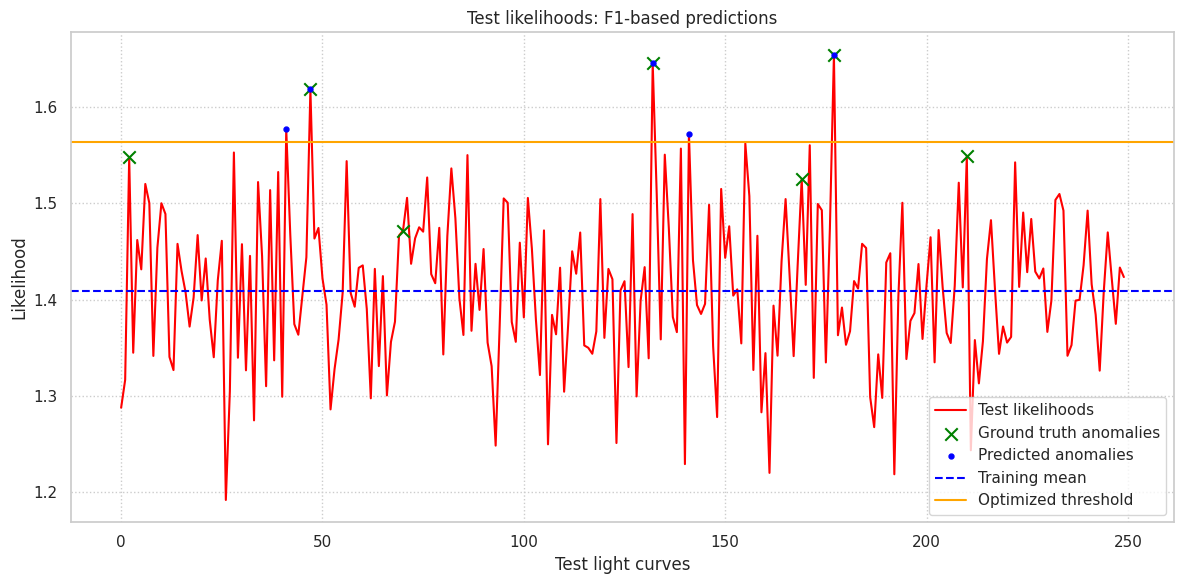

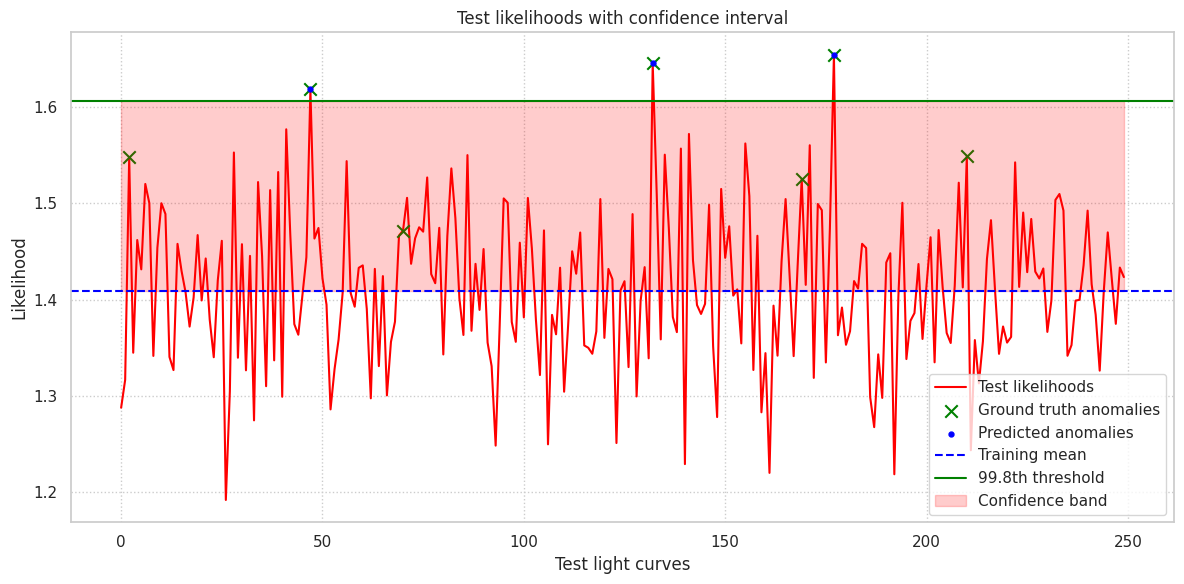

In [158]:
# Generating, scaling and perturbing data
test_data, test_data_perturbed, test_anomaly_indices = prepare_test_data(
    distribution_params, num_samples, chunk_size, test_anomaly_perc,
    burst_strengths, strength_lvl, scaler, peak_time, burst_duration)

# Evaluating model performances (using the metrics above)
conf_matrices, y_true, y_scores, predictions = evaluate_model_performance(
                                    test_data_perturbed, ae_conv,
                                    test_anomaly_indices, best_threshold_conv,
                                    threshold_perc, mean_train_ll_conv)
# Unpack returns
cm_f1, cm_perc = conf_matrices
y_pred_f1, y_pred_perc = predictions

In [159]:
# Print classification reports
print("\n== Classification Report (F1 Threshold) ==")
print(classification_report(y_true, y_pred_f1))
print("== Classification Report (99.8th Percentile) ==")
print(classification_report(y_true, y_pred_perc))


== Classification Report (F1 Threshold) ==
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       243
         1.0       0.60      0.43      0.50         7

    accuracy                           0.98       250
   macro avg       0.79      0.71      0.74       250
weighted avg       0.97      0.98      0.97       250

== Classification Report (99.8th Percentile) ==
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       243
         1.0       1.00      0.43      0.60         7

    accuracy                           0.98       250
   macro avg       0.99      0.71      0.80       250
weighted avg       0.98      0.98      0.98       250



#### Plot metrics

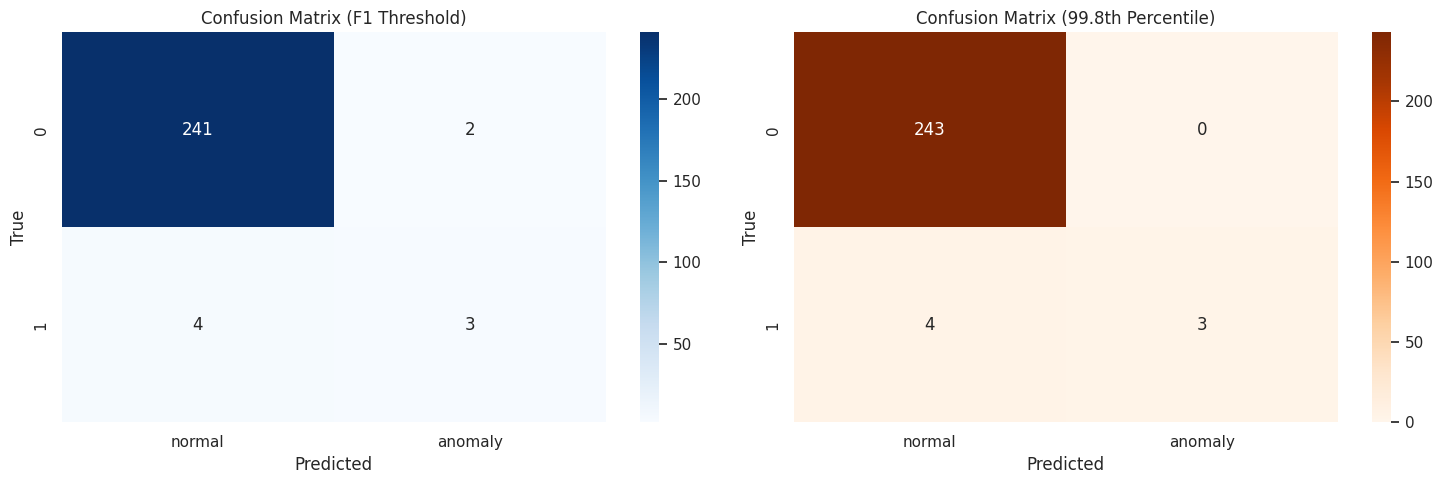

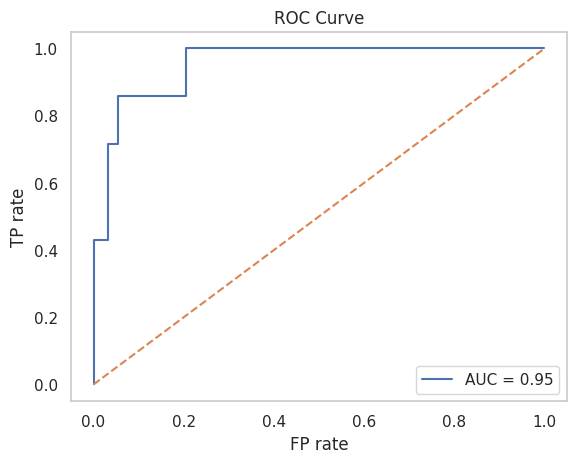

Best threshold (based on F1-score): 1.6181
Best F1-score: 0.6000


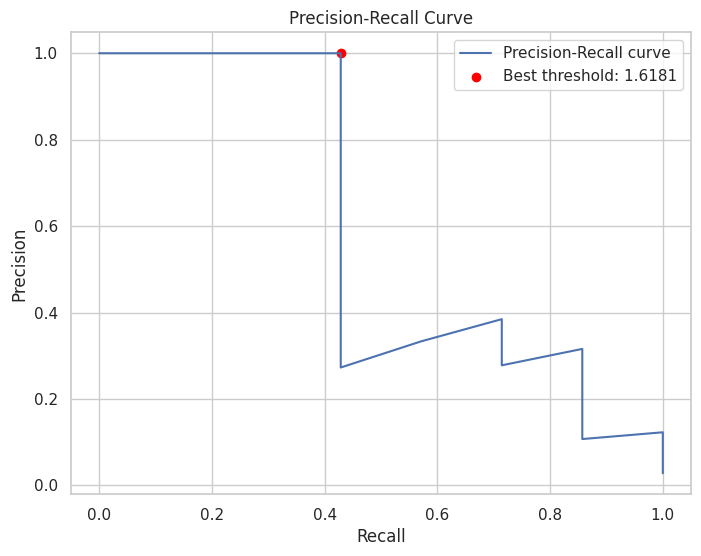

In [160]:
plot_conf_matrices(cm_f1, cm_perc)
plot_ROC(y_true, y_scores)
plot_PR_curve(y_true, y_scores)


##### Dense


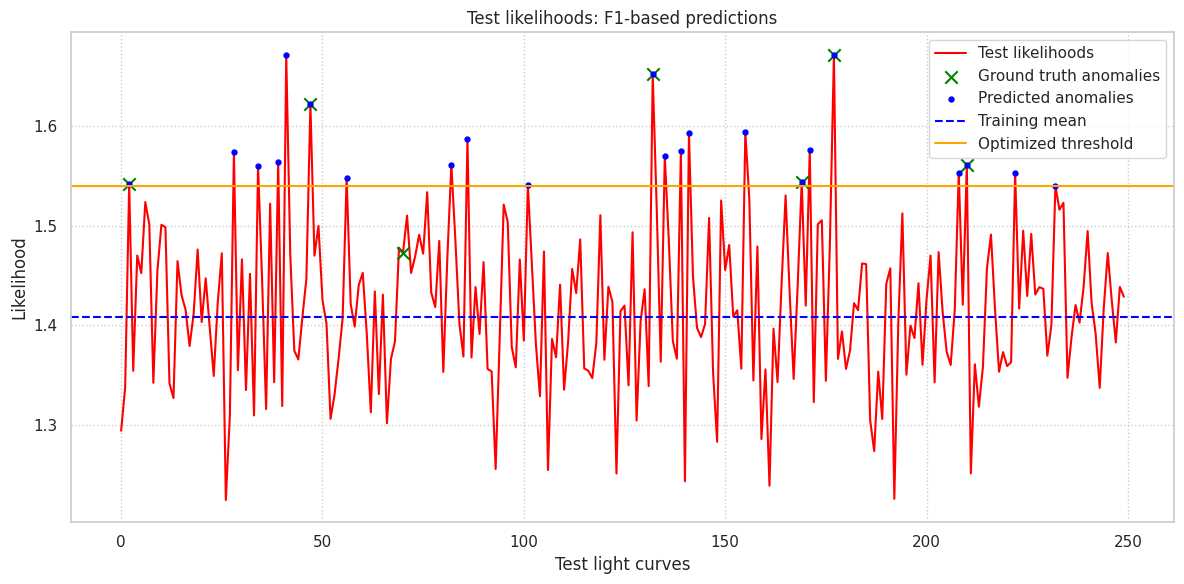

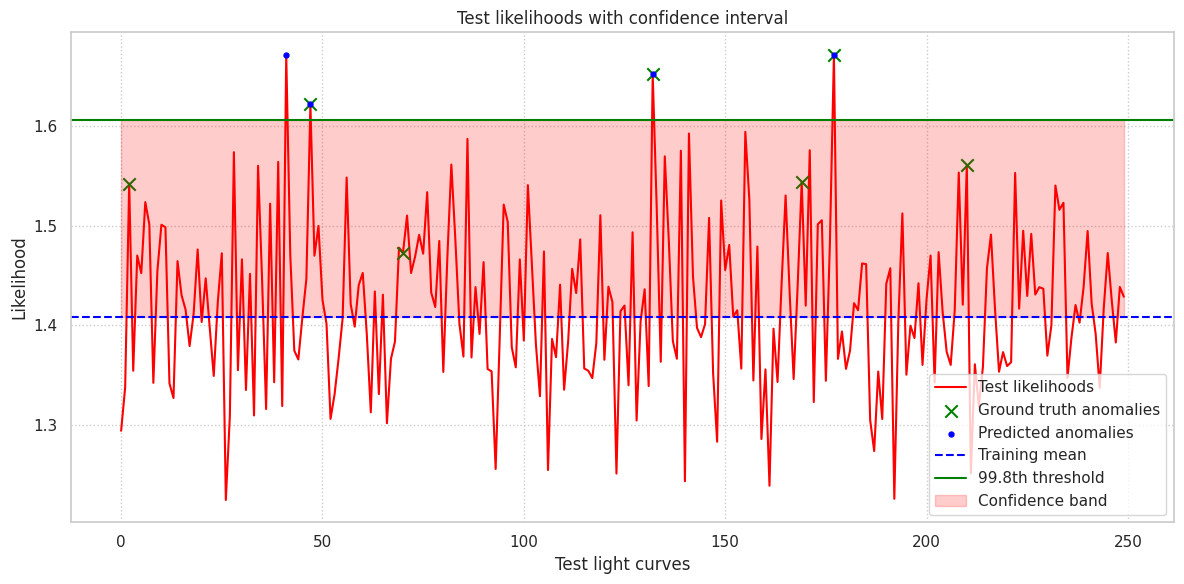

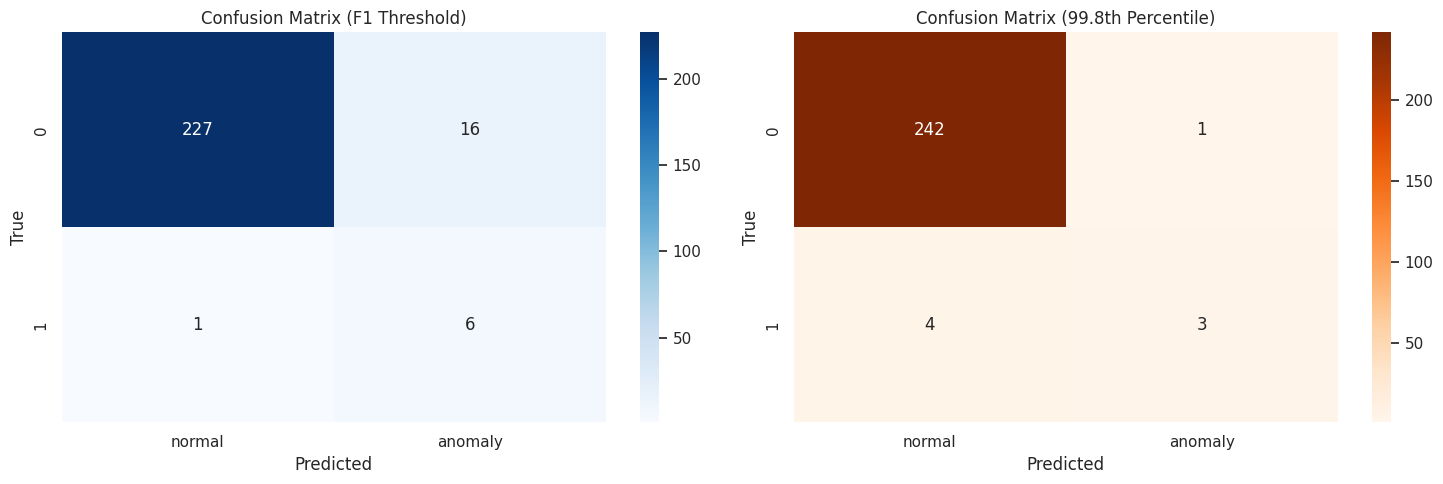

In [161]:
# Evaluating model performances (using the metrics above)
conf_matrices, y_true, y_scores, predictions = evaluate_model_performance(
                                    test_data_perturbed, ae,
                                    test_anomaly_indices, best_threshold_dense,
                                    threshold_perc, mean_train_ll_conv)
# Unpack returns
cm_f1, cm_perc = conf_matrices
y_pred_f1, y_pred_perc = predictions

# Plot metrics
plot_conf_matrices(cm_f1, cm_perc)

> As we can see, the likelihoods computed by the dense model are a bit different

## Considerations

After having tried to use 100'000 training samples instead of just 10'000 samples (not showned here) we have noticed that the evaluation process is more **robust**. This is quite obvious because with more samples the model learns more accurately the statistical properties (mean, variance, skewness) of the underlying distribution (of the background signal). Namely, we generalize better.

**TODO**

*   try other total training **samples** values (tried 10'000 and 100'000)
*   try other chunk **sizes** (now 100) ❌
*   try to **diversify** the perturbation (now always starting at bin n°10 and lasting 20 bins) ❌
  - random perturbations, for example
  - before doing this, just try to see how the model behaves with such a test set
* gridsearch and hyperparameter tuning ✅



## Let's make things more difficult (more realistic, tbh)

Up to now, our perturbation mechanism has been quite naive. Perturbations were always **fixed** — starting at a specific bin and lasting for a predefined number of bins. This simplification benefited even a fully dense architecture, which could capture local patterns under these conditions, achieving performance comparable to that of a 1D convolutional architecture — which is, by default, better suited for handling time-series data.

We will now divide our further analysis into two distinct parts:

1. We will test our models on the previous test set, but perturbated in way such that it will contain **random** bursts, placed at random locations. We expect both models to perform worse, especially the dense model.

2. Next, we will extend our analysis by applying the same methodologies used previously.

In [162]:
def add_random_burst(data, anomaly_indices, anomaly_perc, amplitudes):
  burst_locations = {}

  ## Parameters
  amplitude_lb = amplitudes["lb"]
  amplitude_ub = amplitudes["ub"]
  lambda_lb = 0.05
  lambda_ub = 0.25

  ## Apply anomalies only to a selected percentage of light curves
  perturbed_data = data.copy()
  for i in anomaly_indices:
      # Randomize burst params
      burst_duration = np.random.randint(10, 30)
      peak_time = np.random.randint(0, chunk_size - burst_duration)
      amplitude = np.random.randint(amplitude_lb, amplitude_ub)
      lambd = np.random.uniform(lambda_lb, lambda_ub)

      # Update dict of burst loc
      burst_locations[int(i)] = (peak_time, burst_duration)

      # Add the anomaly
      burst = amplitude * np.exp(-lambd * np.arange(burst_duration))
      perturbed_data[i, peak_time:burst_duration + peak_time] += burst

  return perturbed_data, anomaly_indices, burst_locations

#### Perturb the test set with random bursts

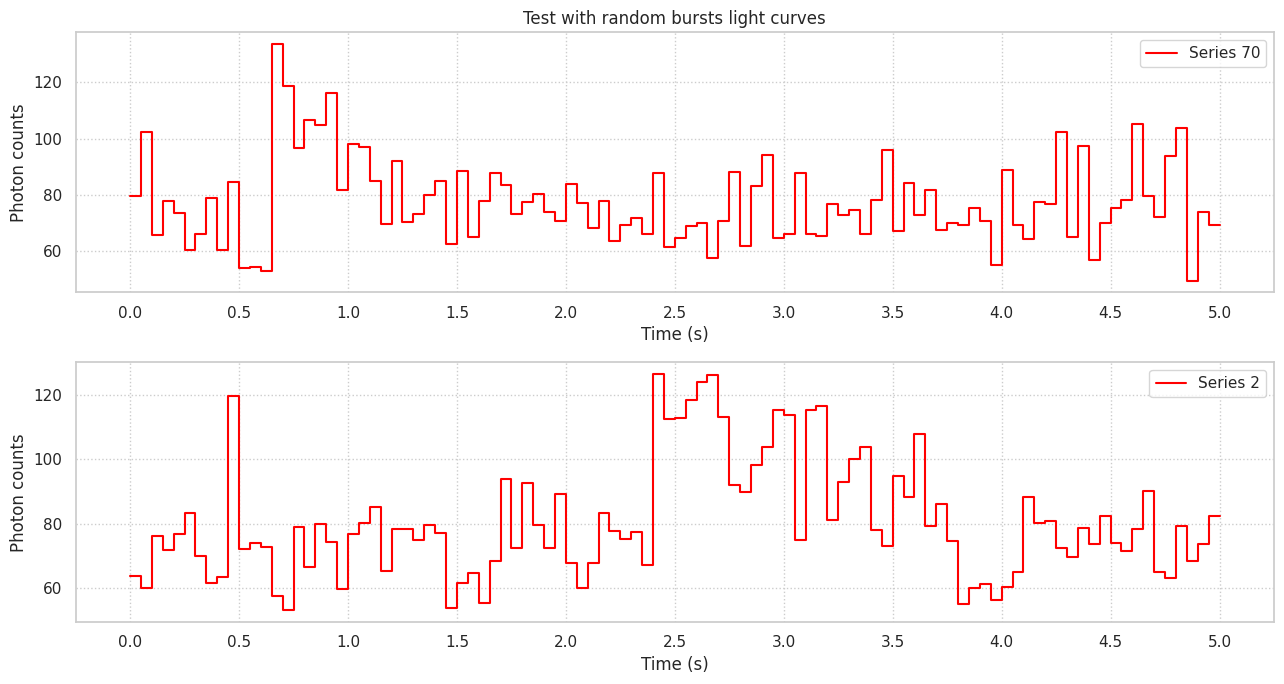

The bursts starts at time ['0.65', '2.40'] with duration of ['1.25', '1.40'] (in seconds), respectively.


In [163]:
# Perturbing
amplitudes = burst_strengths[strength_lvl]
test_data_perturbed, test_anomaly_indices, burst_locations = add_random_burst(
    test_data, test_anomaly_indices, test_anomaly_perc, amplitudes
)

# Choose two random indices
selected_indices = np.random.choice(list(burst_locations.keys()), size=2,
                                    replace=False)
# Showing
show_box_lightcurves(test_data_perturbed, selected_indices=selected_indices,
                     size=2, label="Test with random bursts", color="red")

peak_times = [burst_locations[i][0] for i in selected_indices]
burst_durations = [burst_locations[i][1] for i in selected_indices]

print(f"The bursts starts at time {[f'{peak_time*BIN_DURATION:.2f}' for peak_time in peak_times]} with duration of {[f'{burst_d*BIN_DURATION:.2f}' for burst_d in burst_durations]} (in seconds), respectively.")

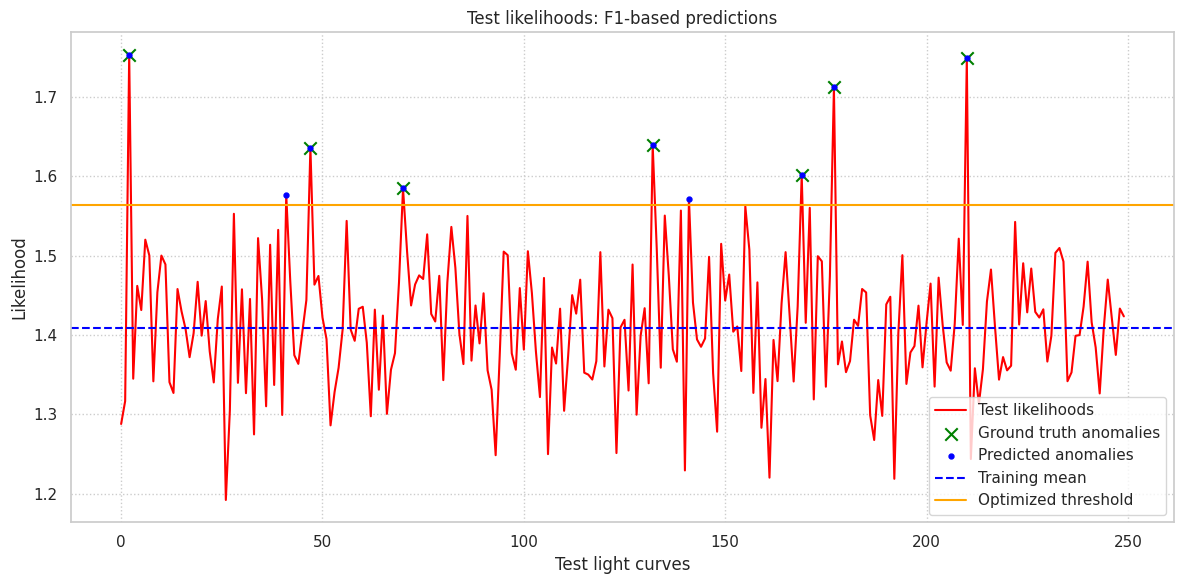

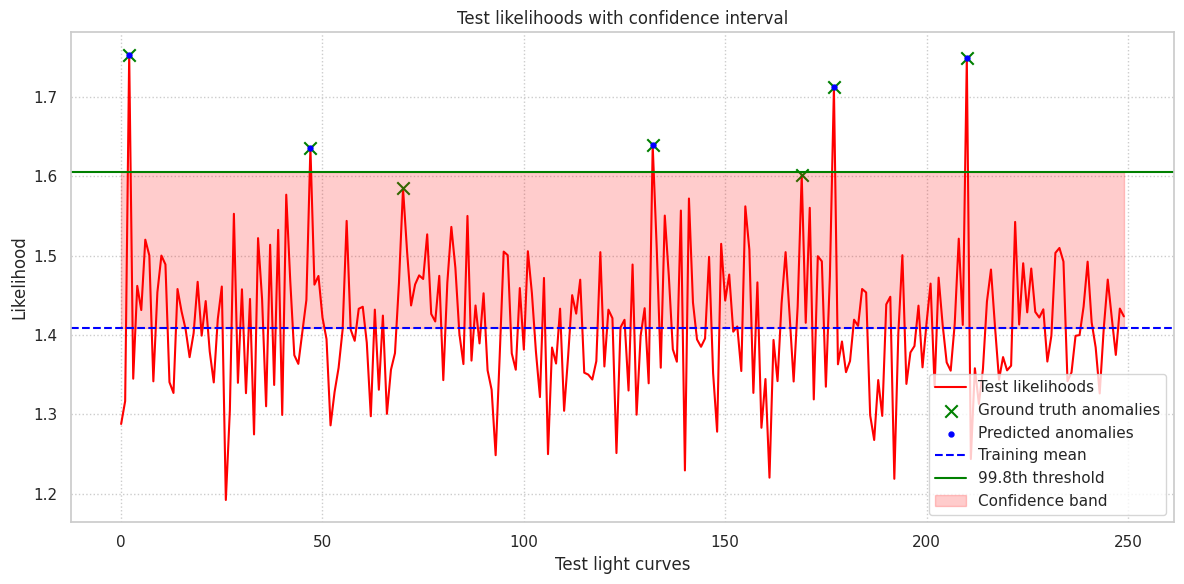

In [164]:
# Scaling data before evaluating the model over them
test_data_perturbed = scaler.transform(test_data_perturbed)

# Evaluating model performances (using the metrics above)
conf_matrices, y_true, y_scores, predictions = evaluate_model_performance(
                                    test_data_perturbed, model,
                                    test_anomaly_indices, best_threshold_conv,
                                    threshold_perc, mean_train_ll_conv)
# Unpack returns
cm_f1, cm_perc = conf_matrices
y_pred_f1, y_pred_perc = predictions

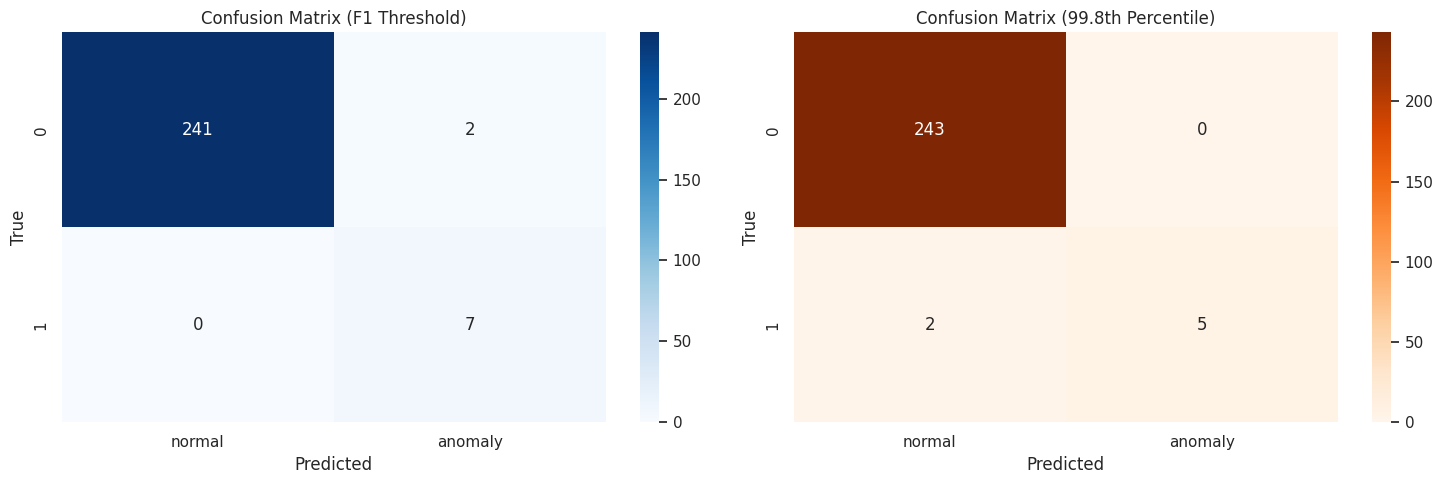

In [165]:
# Plot metrics
plot_conf_matrices(cm_f1, cm_perc)
#plot_ROC(y_true, y_scores)
#plot_PR_curve(y_true, y_scores)

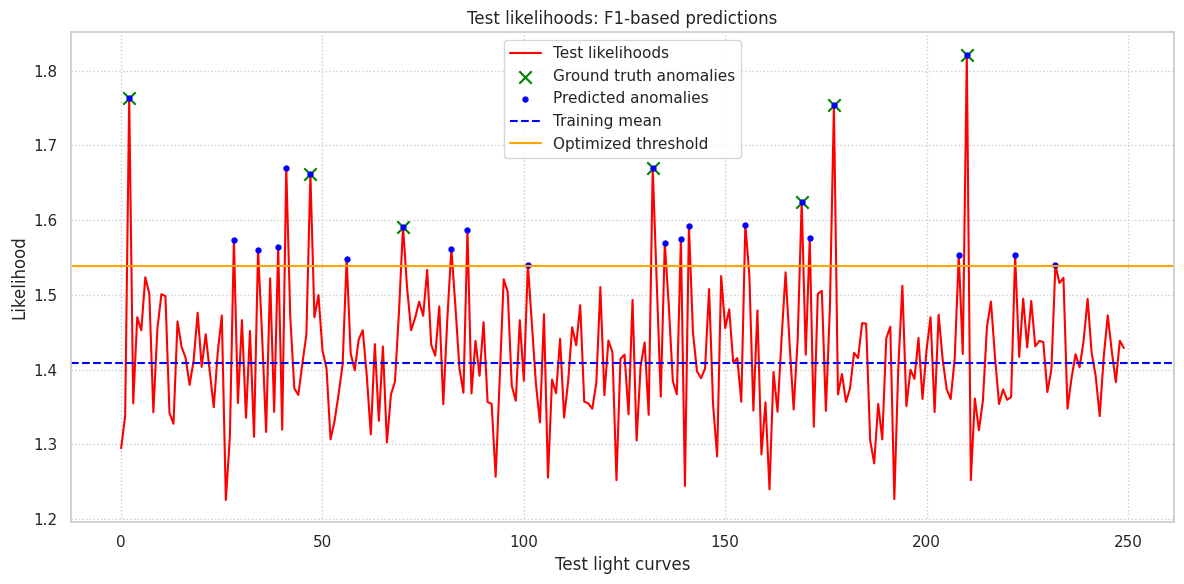

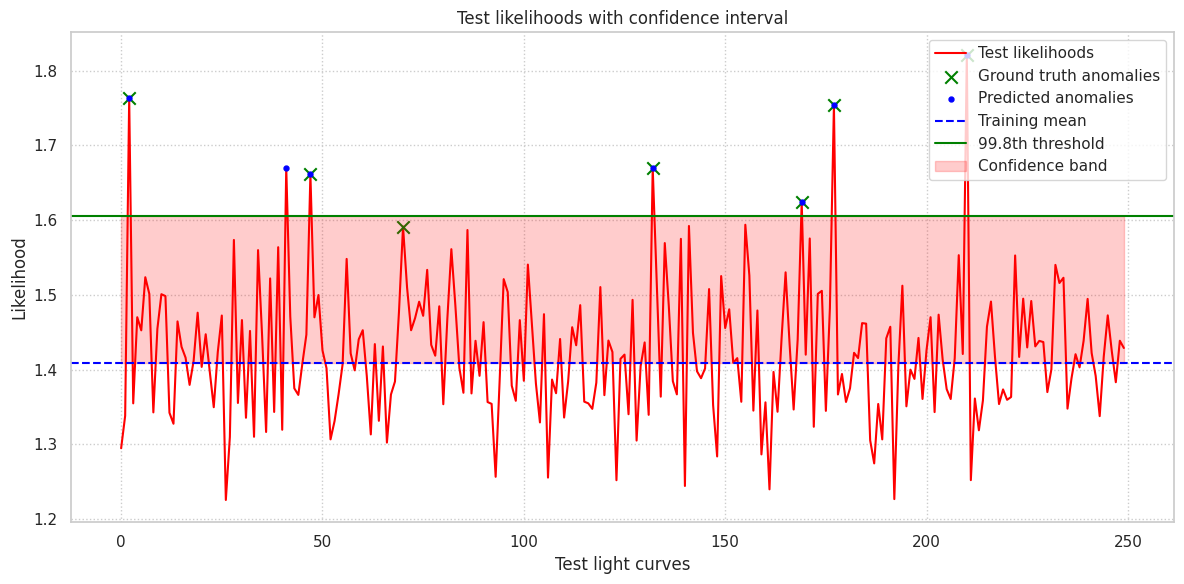

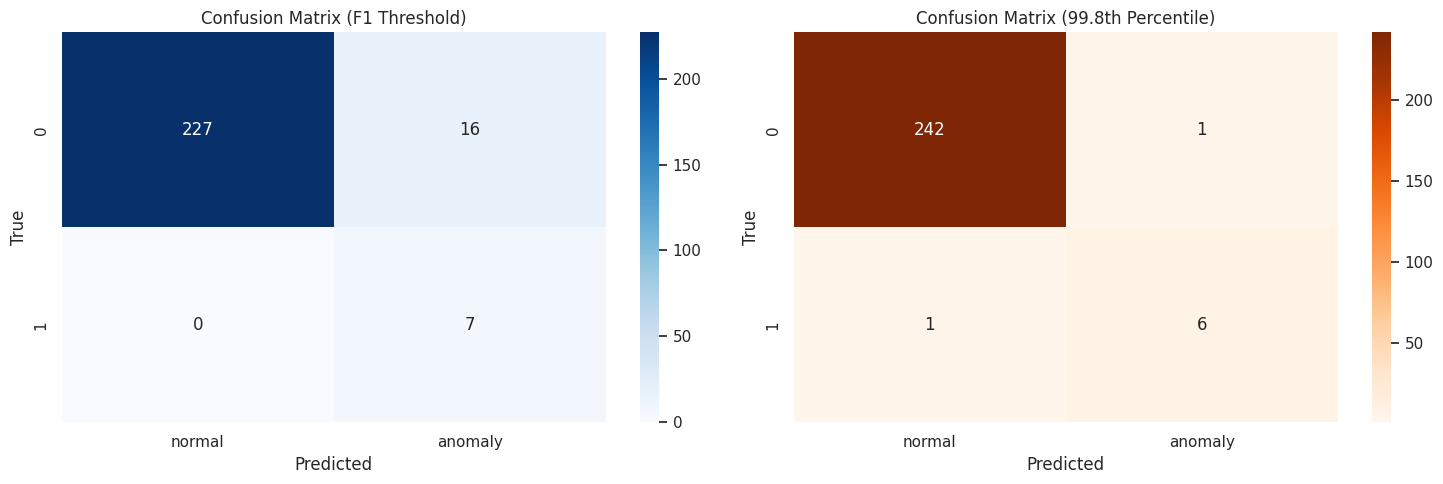

In [166]:
# Evaluating model performances (using the metrics above)
conf_matrices, y_true, y_scores, predictions = evaluate_model_performance(
                                    test_data_perturbed, ae,
                                    test_anomaly_indices, best_threshold_dense,
                                    threshold_perc, mean_train_ll_conv)
# Unpack returns
cm_f1, cm_perc = conf_matrices
y_pred_f1, y_pred_perc = predictions

# Plot metrics
plot_conf_matrices(cm_f1, cm_perc)